## **Import Libraries**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython import display
from tqdm import tqdm

**Mount drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. **Dataset Loading & Visualizing**

In [3]:

dataset_dir = "/content/drive/MyDrive/CVPR/Animals"

def load_and_shuffle_dataset(dataset_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    print(f"Detected classes: {class_names}")

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)


        if not os.path.isdir(class_path):
            print(f"Skipping {class_name}, not a directory.")
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

    labels = np.array(labels)

    # Shuffle dataset
    print("Shuffling the dataset...")
    indices = np.arange(len(image_paths))
    np.random.shuffle(indices)
    image_paths = np.array(image_paths)[indices]
    labels = labels[indices]

    return image_paths, labels, class_names

# Load and shuffle the dataset
image_paths, labels, class_names = load_and_shuffle_dataset(dataset_dir)
print(f"Shuffled and loaded {len(image_paths)} image paths with corresponding labels.")

Detected classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']
Shuffling the dataset...
Shuffled and loaded 170 image paths with corresponding labels.


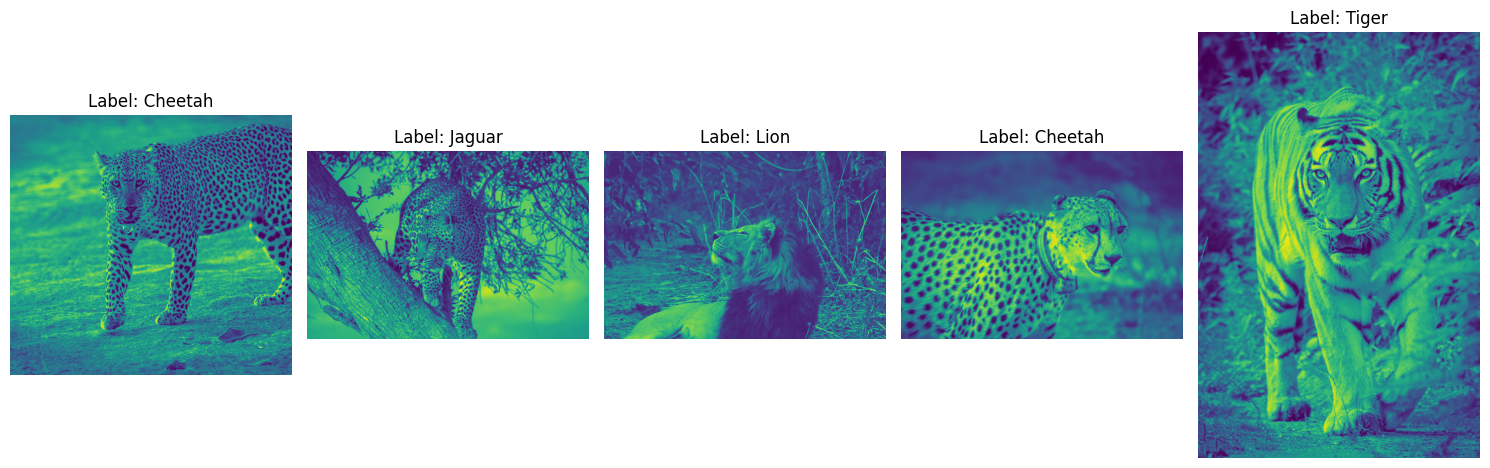

In [4]:
# correct labels
def visualize_samples(image_paths, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize 5 random samples
visualize_samples(image_paths, labels, num_samples=5)

## **2. Data Preprocessing**

In [5]:
def preprocess_images(image_paths, labels, img_size=(64, 64)):
    processed_images = []


    for img_path, label in tqdm(zip(image_paths, labels), desc="Preprocessing images"):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            img = cv2.resize(img, img_size)
            processed_images.append(img)
        except Exception as e:
            print(f"Error {img_path}: {e}")


    processed_images = np.array(processed_images)

    # Normalize pixel values to be between 0 and 1
    processed_images = processed_images.astype("float32") / 255.0

    print(f"Processed {len(processed_images)} images with shape {processed_images.shape}.")

    # Reshape the images into 1D feature vectors
    processed_images = processed_images.reshape(processed_images.shape[0], -1)
    print(f"Reshaped images into {processed_images.shape[0]} samples with {processed_images.shape[1]} features each.")

    return processed_images, labels  # Return both features and labels


X, y = preprocess_images(image_paths, labels)



Preprocessing images: 170it [00:02, 68.67it/s]


Processed 170 images with shape (170, 64, 64).
Reshaped images into 170 samples with 4096 features each.


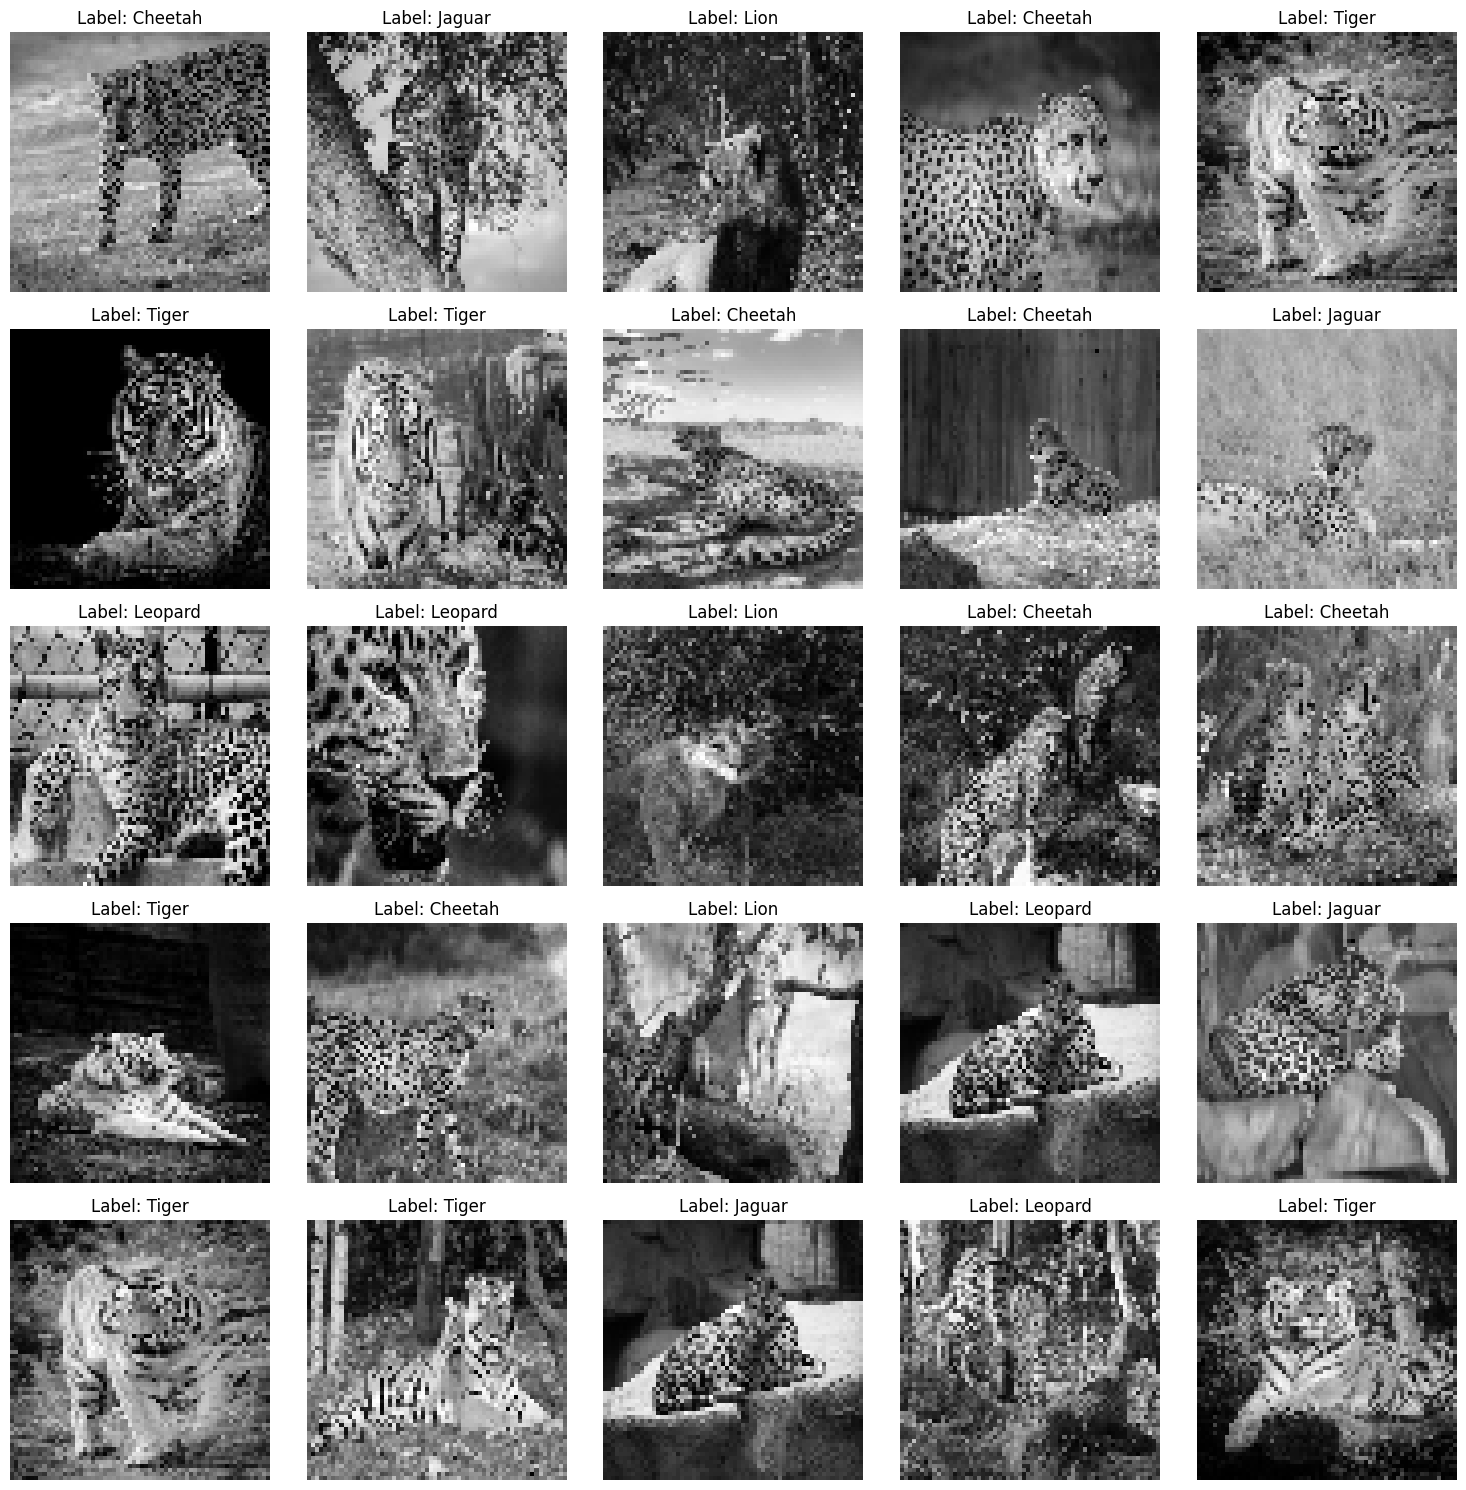

In [6]:
def visualize_images(images, labels, img_size=(64, 64), grid_size=(5, 5)):
    # Create a grid of subplots with the specified grid_size
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            idx = i * grid_size[1] + j  # Calculate the index of the image to be displayed
            if idx < len(images):
                img_reshaped = images[idx].reshape(img_size)  # Reshape 1D vector to 2D (64x64)
                axes[i, j].imshow(img_reshaped, cmap='gray')  # Display image
                axes[i, j].set_title(f"Label: {labels[idx]}")  # Set title for the subplot
                axes[i, j].axis('off')  # Hide axes for better visualization
            else:
                axes[i, j].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

visualize_images(X, y, img_size=(64, 64), grid_size=(5, 5))  # Visualize first 25 images


### **3. 5-Fold Cross-Validation Setup**

In [7]:
# calculate Euclidean distance
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

# Manually perform 5-Fold Cross Validation
def cross_validate(X, y, num_folds=5):
    fold_size = len(X) // num_folds

    for fold in range(num_folds):
        # Split the dataset into training and validation sets
        start_val = fold * fold_size
        end_val = (fold + 1) * fold_size
        X_val, y_val = X[start_val:end_val], y[start_val:end_val]
        X_train = np.concatenate([X[:start_val], X[end_val:]], axis=0)
        y_train = np.concatenate([y[:start_val], y[end_val:]], axis=0)

        print(f"\n----- Fold {fold + 1} -----")
        print(f"Validation Set Size: {len(X_val)} | Training Set Size: {len(X_train)}")

        # For each test image in the validation set, calculate the Euclidean distance to each training image
        for i, (test_image, true_label) in enumerate(zip(X_val, y_val)):
            # Calculate the Euclidean distance between the test image and all training images
            distances = [euclidean_distance(test_image, train_image) for train_image in X_train]

            # Display the results
            print(f"\nTest Image {i + 1} (True Label: {true_label}):")
            print(f"Distances to Training Images: {distances[:5]}...")  # Display first 5 distances for brevity

# Run 5-Fold Cross Validation
cross_validate(X, y, num_folds=5)



----- Fold 1 -----
Validation Set Size: 34 | Training Set Size: 136

Test Image 1 (True Label: Cheetah):
Distances to Training Images: [17.267565, 25.616793, 20.974047, 19.44943, 20.295124]...

Test Image 2 (True Label: Jaguar):
Distances to Training Images: [17.64265, 23.554045, 18.26994, 17.010721, 19.325481]...

Test Image 3 (True Label: Lion):
Distances to Training Images: [18.630735, 20.382992, 13.243944, 17.500622, 18.309387]...

Test Image 4 (True Label: Cheetah):
Distances to Training Images: [17.6556, 18.557016, 13.575706, 16.861391, 17.982403]...

Test Image 5 (True Label: Tiger):
Distances to Training Images: [18.816402, 22.13031, 19.868656, 19.09171, 20.256987]...

Test Image 6 (True Label: Tiger):
Distances to Training Images: [24.96018, 19.323511, 15.552445, 22.273481, 23.1445]...

Test Image 7 (True Label: Tiger):
Distances to Training Images: [19.214556, 26.124693, 22.321297, 21.211027, 21.537838]...

Test Image 8 (True Label: Cheetah):
Distances to Training Images: [2

## **4. k-NN Classification with Euclidean Distance**

In [8]:
from collections import Counter

# perform k-NN classification
def knn_classify(X_train, y_train, test_image, k):
    # Calculate the Euclidean distance between the test image and all training images
    distances = [euclidean_distance(test_image, train_image) for train_image in X_train]

    # Get the indices of the k smallest distances
    k_nearest_indices = np.argsort(distances)[:k]

    # Get the labels of the k nearest neighbors
    k_nearest_labels = [y_train[i] for i in k_nearest_indices]
    most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
    return most_common_label

# Function to perform k-NN with 5-Fold Cross Validation and calculate accuracies
def cross_validate_knn(X, y, num_folds=5, k_values=range(1, 31)):
    fold_size = len(X) // num_folds
    accuracies = {k: [] for k in k_values}  # To store accuracies for each k value

    # 5-Fold Cross Validation
    for fold in range(num_folds):
        # Split dataset into training and validation sets
        start_val = fold * fold_size
        end_val = (fold + 1) * fold_size
        X_val, y_val = X[start_val:end_val], y[start_val:end_val]
        X_train = np.concatenate([X[:start_val], X[end_val:]], axis=0)
        y_train = np.concatenate([y[:start_val], y[end_val:]], axis=0)

        # For each value of K
        for k in k_values:
            correct = 0
            for i, (test_image, true_label) in enumerate(zip(X_val, y_val)):
                # Apply k-NN classification to predict the label
                predicted_label = knn_classify(X_train, y_train, test_image, k)

                # Check if the prediction is correct
                if predicted_label == true_label:
                    correct += 1

            accuracy = correct / len(X_val)
            accuracies[k].append(accuracy)

    # Output the accuracy for each fold and K value
    for k in k_values:
        print(f"K = {k}:")
        for fold, accuracy in enumerate(accuracies[k]):
            print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")
        print()  # New line for better readability

# Run the k-NN classification with cross-validation
cross_validate_knn(X, y, num_folds=5, k_values=range(1, 31))

K = 1:
  Fold 1: Accuracy = 0.1471
  Fold 2: Accuracy = 0.1765
  Fold 3: Accuracy = 0.1765
  Fold 4: Accuracy = 0.1765
  Fold 5: Accuracy = 0.1471

K = 2:
  Fold 1: Accuracy = 0.1471
  Fold 2: Accuracy = 0.1765
  Fold 3: Accuracy = 0.1765
  Fold 4: Accuracy = 0.1765
  Fold 5: Accuracy = 0.1471

K = 3:
  Fold 1: Accuracy = 0.2059
  Fold 2: Accuracy = 0.1765
  Fold 3: Accuracy = 0.1471
  Fold 4: Accuracy = 0.0882
  Fold 5: Accuracy = 0.1765

K = 4:
  Fold 1: Accuracy = 0.2059
  Fold 2: Accuracy = 0.2647
  Fold 3: Accuracy = 0.1765
  Fold 4: Accuracy = 0.0588
  Fold 5: Accuracy = 0.0588

K = 5:
  Fold 1: Accuracy = 0.2059
  Fold 2: Accuracy = 0.2353
  Fold 3: Accuracy = 0.2353
  Fold 4: Accuracy = 0.0588
  Fold 5: Accuracy = 0.1176

K = 6:
  Fold 1: Accuracy = 0.0882
  Fold 2: Accuracy = 0.2059
  Fold 3: Accuracy = 0.1471
  Fold 4: Accuracy = 0.0882
  Fold 5: Accuracy = 0.2353

K = 7:
  Fold 1: Accuracy = 0.1176
  Fold 2: Accuracy = 0.1176
  Fold 3: Accuracy = 0.1765
  Fold 4: Accuracy = 

**5. Cross-Validation and Accuracy Calculation**

In [9]:
def centroid(X, y, num_folds=5, k_values=range(1, 31)):
    fold_size = len(X) // num_folds
    accuracies = {k: [] for k in k_values}

    for fold in range(num_folds):
        start_val = fold * fold_size
        end_val = (fold + 1) * fold_size
        X_val, y_val = X[start_val:end_val], y[start_val:end_val]
        X_train = np.concatenate([X[:start_val], X[end_val:]], axis=0)
        y_train = np.concatenate([y[:start_val], y[end_val:]], axis=0)

        for k in k_values:
            correct = 0
            for test_image, true_label in zip(X_val, y_val):
                predicted_label = knn_classify(X_train, y_train, test_image, k)
                if predicted_label == true_label:
                    correct += 1
            accuracy = correct / len(X_val)
            accuracies[k].append(accuracy)

    # Calculate and return centroids (mean accuracies)
    centroids = {k: np.mean(acc) for k, acc in accuracies.items()}
    return centroids

# Run cross-validation and get centroids
centroids = centroid(X, y, num_folds=5, k_values=range(1, 31))

# Print centroids
for k, centroid in centroids.items():
    print(f"K = {k}, Centroid (Mean Accuracy) = {centroid:.4f}")


K = 1, Centroid (Mean Accuracy) = 0.1647
K = 2, Centroid (Mean Accuracy) = 0.1647
K = 3, Centroid (Mean Accuracy) = 0.1588
K = 4, Centroid (Mean Accuracy) = 0.1529
K = 5, Centroid (Mean Accuracy) = 0.1706
K = 6, Centroid (Mean Accuracy) = 0.1529
K = 7, Centroid (Mean Accuracy) = 0.1529
K = 8, Centroid (Mean Accuracy) = 0.1588
K = 9, Centroid (Mean Accuracy) = 0.1471
K = 10, Centroid (Mean Accuracy) = 0.1529
K = 11, Centroid (Mean Accuracy) = 0.1765
K = 12, Centroid (Mean Accuracy) = 0.1412
K = 13, Centroid (Mean Accuracy) = 0.1706
K = 14, Centroid (Mean Accuracy) = 0.1647
K = 15, Centroid (Mean Accuracy) = 0.1706
K = 16, Centroid (Mean Accuracy) = 0.1706
K = 17, Centroid (Mean Accuracy) = 0.1941
K = 18, Centroid (Mean Accuracy) = 0.2118
K = 19, Centroid (Mean Accuracy) = 0.1882
K = 20, Centroid (Mean Accuracy) = 0.1882
K = 21, Centroid (Mean Accuracy) = 0.1706
K = 22, Centroid (Mean Accuracy) = 0.1706
K = 23, Centroid (Mean Accuracy) = 0.2059
K = 24, Centroid (Mean Accuracy) = 0.2059
K

### **6.Average Accuracy and Centroid Calculation**

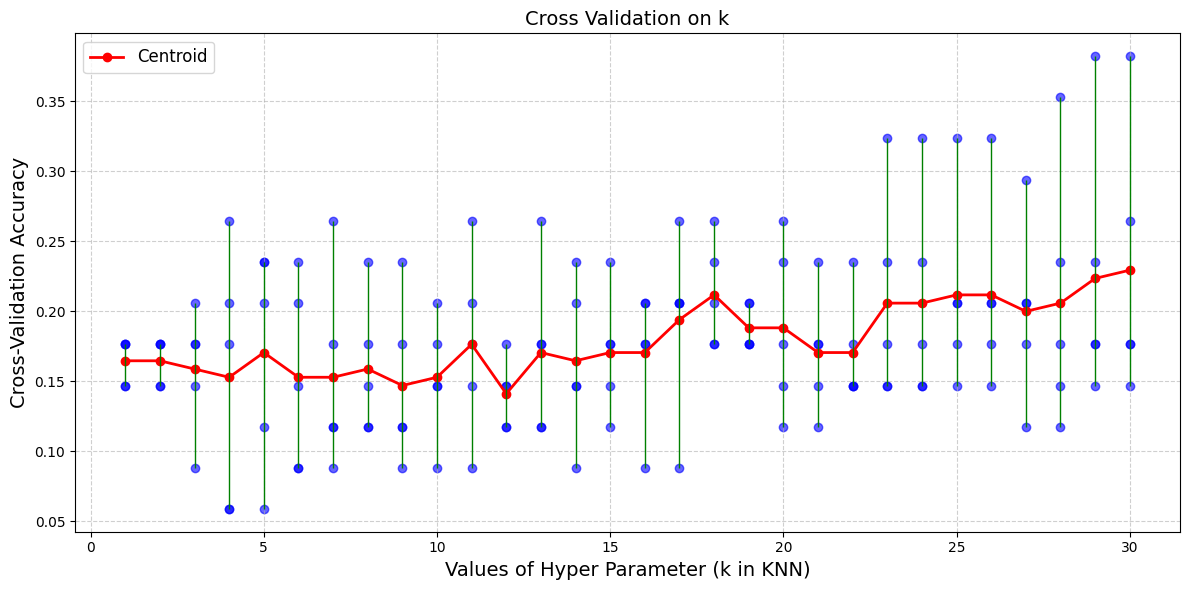

In [21]:
def knn_plotting(X, y, num_folds=5, k_values=range(1, 31)):
    fold_size = len(X) // num_folds
    accuracies = {k: [] for k in k_values}

    for fold in range(num_folds):
        start_val = fold * fold_size
        end_val = (fold + 1) * fold_size
        X_val, y_val = X[start_val:end_val], y[start_val:end_val]
        X_train = np.concatenate([X[:start_val], X[end_val:]], axis=0)
        y_train = np.concatenate([y[:start_val], y[end_val:]], axis=0)

        for k in k_values:
            correct = 0
            for test_image, true_label in zip(X_val, y_val):
                predicted_label = knn_classify(X_train, y_train, test_image, k)
                if predicted_label == true_label:
                    correct += 1
            accuracy = correct / len(X_val)
            accuracies[k].append(accuracy)


    centroids = {k: np.mean(acc) for k, acc in accuracies.items()}
    return accuracies, centroids


accuracies, centroids = knn_plotting(X, y, num_folds=5, k_values=range(1, 31))

errors = []


for k, fold_accuracies in accuracies.items():
    error = np.ptp(fold_accuracies)  # ptp gives the range (max - min)
    errors.append(error)


k_values = list(accuracies.keys())


plt.figure(figsize=(12, 6))
plt.title("Cross Validation on k", fontsize=14)
plt.xlabel("Values of Hyper Parameter (k in KNN)", fontsize=14)
plt.ylabel("Cross-Validation Accuracy", fontsize=14)


plt.plot(k_values, list(centroids.values()), color='r', marker='o', linewidth=2, label="Centroid")

# Add vertical lines for accuracy ranges (min-max) and scatter plot for fold accuracies
for k, fold_accuracies in accuracies.items():
    min_acc = min(fold_accuracies)
    max_acc = max(fold_accuracies)
    avg_acc = np.mean(fold_accuracies)

    # Draw vertical line for range (min to max accuracy)
    plt.vlines(x=k, ymin=min_acc, ymax=max_acc, color='green', linewidth=1)
    plt.scatter([k] * len(fold_accuracies), fold_accuracies, color='blue', alpha=0.6)


plt.legend(["Centroid"], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()